# batchsize 4 | lr 0.0001 with lrScheduler | higher epochs?

In [1]:
%matplotlib inline

### 0. importing

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import tqdm

print (torch.__version__)

2.0.1


In [3]:
root_dir = "images/"

### 1. 이미지 로드 및 전처리(Augmentation?)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)

total_size = len(dataset)
reduced_size = int(total_size * 0.35)  # reduce to 35%

reduced_dataset, _ = torch.utils.data.random_split(dataset, [reduced_size, total_size - reduced_size])

# Split the reduced dataset into train, test and validation datasets
train_size = int(0.7 * len(reduced_dataset))  # 70% of reduced_size
val_size = int(0.15 * len(reduced_dataset))  # 15% of reduced_size
test_size = len(reduced_dataset) - train_size - val_size  # Remaining 15% for testing

trainset, valset, testset = torch.utils.data.random_split(reduced_dataset, [train_size, val_size, test_size])

print("Trainset size:", len(trainset))
print("Validation set size:", len(valset))
print("Testset size:", len(testset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=True, num_workers=2)

classes = ('angry', 'happy', 'relaxed', 'sad')

Trainset size: 3900
Validation set size: 835
Testset size: 837


### 2. 이미지 확인

GroundTruth:
                   sad                   sad                   sad                 angry


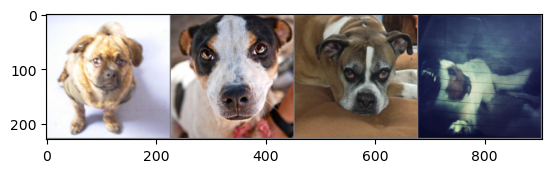

In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth:')
print(''.join('%22s' % classes[labels[j]] for j in range(4)))

라벨-이미지 안 맞는 것처럼 보이는 것이 있지만,, 직접 확인함,,,

### 3. Colab GPU 사용 설정

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### 4. Pre-trained ResNet-18 모델 불러오기
....  scratch  방식으로 구현하려 했으나 시간이 너무 오래 걸려서 pre-trained & fine-tuning으로 구현

In [7]:
import torchvision.models as models

# Load pretrained ResNet18
model = models.resnet50(weights = 'ResNet50_Weights.DEFAULT')

# Freeze the earlier layers and only train the later layers(fc)
for param in model.parameters():
    param.requires_grad = False
    
# Adjust the final layer
# Final Fully Connected Layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4: number of your classes 

model = model.to(device)

### 5. Loss Function & Optimizer 정의

In [8]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimzer
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum = 0.9)

# Learning Rate Scheduler -> ReduceLROnPlateau: reduce LR on val_loss not improved (default factor 0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

### 6. Train & Validation

In [ ]:
from tqdm import tqdm

# Number of epochs
num_epochs = 100

# Loop over the epochs
for epoch in range(num_epochs):
    
    # Switch model to training mode
    model.train()
    
    # Initialize running loss
    running_loss = 0.0

    # Progress bar
    pbar_train = tqdm(enumerate(trainloader), total=len(trainloader))
    
    # Loop over the data in the data loader
    for i, (inputs, targets) in pbar_train:

        # Get the inputs and move them to the specified device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

         # Update progress bar
        pbar_train.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch+1, i * len(inputs), len(trainloader.dataset), 100. * i / len(trainloader), loss.item()))
        
        
    # Print loss for this epoch
    print('Train Epoch: [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/len(trainloader)))
    
    # Validation 
    model.eval()
    val_loss = 0.0
    correct = 0
    
    # Progress bar for validation
    pbar_val = tqdm(enumerate(valloader), total=len(valloader))
    
    with torch.no_grad():
        for i, (inputs, targets) in pbar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()  # sum up batch loss
            _, predicted = outputs.max(1)  # get index of the max probability
            correct += predicted.eq(targets.view_as(predicted)).sum().item()
            
            # Update progress bar
            pbar_val.set_description('Val Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch+1, i * len(inputs), len(valloader.dataset), 100. * i / len(valloader), val_loss / (i+1)))
            
    val_loss /= len(valloader.dataset)
    
    scheduler.step(val_loss)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(val_loss, correct, len(valloader.dataset), 100. * correct / len(valloader.dataset)))

Train Epoch: 1 [3896/3900 (100%)]	Loss: 1.521550: 100%|██████████████████████████████| 975/975 [01:22<00:00, 11.86it/s]


Train Epoch: [1/100], Loss: 1.3309


Val Epoch: 1 [624/835 (100%)]	Loss: 1.296828: 100%|██████████████████████████████████| 209/209 [00:15<00:00, 13.38it/s]



Validation set: Average loss: 0.3246, Accuracy: 361/835 (43%)



Train Epoch: 2 [3896/3900 (100%)]	Loss: 1.258206: 100%|██████████████████████████████| 975/975 [01:13<00:00, 13.31it/s]


Train Epoch: [2/100], Loss: 1.2827


Val Epoch: 2 [624/835 (100%)]	Loss: 1.265687: 100%|██████████████████████████████████| 209/209 [00:15<00:00, 13.77it/s]



Validation set: Average loss: 0.3168, Accuracy: 377/835 (45%)



Train Epoch: 3 [3896/3900 (100%)]	Loss: 0.914105: 100%|██████████████████████████████| 975/975 [01:13<00:00, 13.26it/s]


Train Epoch: [3/100], Loss: 1.2496


Val Epoch: 3 [624/835 (100%)]	Loss: 1.245508: 100%|██████████████████████████████████| 209/209 [00:15<00:00, 13.30it/s]



Validation set: Average loss: 0.3117, Accuracy: 382/835 (46%)



Train Epoch: 4 [3896/3900 (100%)]	Loss: 1.264396: 100%|██████████████████████████████| 975/975 [01:12<00:00, 13.44it/s]


Train Epoch: [4/100], Loss: 1.2272


Val Epoch: 4 [624/835 (100%)]	Loss: 1.228976: 100%|██████████████████████████████████| 209/209 [00:14<00:00, 14.08it/s]



Validation set: Average loss: 0.3076, Accuracy: 384/835 (46%)



Train Epoch: 5 [3896/3900 (100%)]	Loss: 1.054044: 100%|██████████████████████████████| 975/975 [01:11<00:00, 13.56it/s]


Train Epoch: [5/100], Loss: 1.2115


Val Epoch: 5 [624/835 (100%)]	Loss: 1.215673: 100%|██████████████████████████████████| 209/209 [00:14<00:00, 14.08it/s]



Validation set: Average loss: 0.3043, Accuracy: 403/835 (48%)



Train Epoch: 6 [3896/3900 (100%)]	Loss: 1.370761: 100%|██████████████████████████████| 975/975 [01:12<00:00, 13.51it/s]


Train Epoch: [6/100], Loss: 1.1945


Val Epoch: 6 [624/835 (100%)]	Loss: 1.194637: 100%|██████████████████████████████████| 209/209 [00:15<00:00, 13.71it/s]



Validation set: Average loss: 0.2990, Accuracy: 408/835 (49%)



### 7. Test the Network on the test data

In [ ]:
# Initialize counters
correct = 0
total = 0

# Switch model to evaluation mode
model.eval()

# Disabling gradient calculation
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)                                    # Forward pass only to get outputs
        _, predicted = torch.max(outputs.data, 1)                  # Get predicted class from the maximum value
        total += labels.size(0)                                    # Total number of labels
        correct += (predicted == labels).sum().item()              # Total correct predictions

print('Accuracy of the model on the test images: %.2f %%' % (100 * correct / total))

### 8. Class(감정)별 정확도 계산

In [ ]:
# Accuracy for each emotion
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            correct = c.item() if c.dim() == 0 else c[i].item() 
            class_correct[label] += correct
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

### 9. Showing Image-Label

In [ ]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predict labels
outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

def imshow(img):
    img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Images with true and predicted labels
imshow(torchvision.utils.make_grid(images))
print('True labels: ')
print(''.join('%18s' % classes[labels[j]] for j in range(4)))
print('Predicted labels: ')
print(''.join('%18s' % classes[predicted[j]] for j in range(4)))